# 1. Install dependencies and libraries

In [142]:
import os
import numpy as np
from skimage import io
from skimage.color import gray2rgb
import skimage.transform
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
import math
from sklearn.metrics import accuracy_score

# 2. Load Images
## 2.1. Load image directories into numpy arrays

In [143]:
## file_num: based on the name of folder; this number might change where we take from after it the name of files

def load_images(file_num, folder_name):
    dict_img = {}
    for root, _, files in os.walk(folder_name, topdown=False):
    #     print(root[9])
        dict_img[root[file_num:]] = np.array([root+ '\\' + i for i in files])
    leaf1 = dict_img.get('1')
    leaf2 = dict_img.get('2')
    leaf3 = dict_img.get('3')
    leaf4 = dict_img.get('4')
    leaf6 = dict_img.get('6')
    args = (leaf1, leaf2, leaf3, leaf4, leaf6)
    all_arr = np.concatenate(args)
    
    return all_arr

### 2.2. Construct labels

In [144]:
### pass the length directly which is the len(all_arr),,, label: list of the required numbers

## Partition: number of files per folder/class to cut on, length: length of training data array, labels: a list for the labels you want 
def make_label(partition, length, labels):
    y = np.zeros(length)
    y[0:partition] = labels[0]
    y[partition:2*partition] = labels[1]
    y[2*partition:3*partition] = labels[2]
    y[3*partition:4*partition] = labels[3]
    y[4*partition:5*partition] = labels[4]
    
    return y

# 3. Reading the images
## 3.1. Read and resize images

In [145]:
## size is a number: 64

def read_images(all_arr, size):
    imgs_resize = []
    for i in all_arr:
        x = io.imread(i)
        imgs_resize.append(skimage.transform.resize(x, (size,size), preserve_range=True))  
    return imgs_resize

- We will try learning by resizing the images into 64x64 

# 4. VGG16 Loading

In [146]:
## the 64 here should map to the 'size' variable
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

for layer in vgg_model.layers:
    layer.trainable = False
    
# last layers output
x_orig = vgg_model.layers[6].output

## 4.1 VGG16 finetuning (Classification)

In [147]:
### Conv/fully ==> no more than 5,, pool/flatten/1D conv ==> as many
x = Flatten()(x_orig)
x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='sigmoid')(x)
x = Dense(5, activation='softmax')(x) ## will be 1 in regression and make the y labels as usual [1, 2, 3, 4, 6]

vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer.summary())

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

## 4.2. Fit the model

### 4.2.1. Load the data
#### 4.2.1.1. Train data

In [148]:
all_arr = load_images(9, "training")
y = make_label(180, len(all_arr), [0, 1, 2, 3, 4])
imgs_resize = read_images(all_arr, 64)

#### 4.2.1.2. Test data

In [149]:
all_arr_test = load_images(-1, "testing")
y_t = make_label(20, len(all_arr_test), [0, 1, 2, 3, 4])
imgs_resize_test = read_images(all_arr_test, 64)
imgs_resize_test = np.array(imgs_resize_test)

### 4.2.2. Split the data

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split(imgs_resize, y, test_size=0.3, random_state=30)
X_train = np.array(X_train)
X_valid = np.array(X_valid)
print('Training data shape: ',X_train.shape, ' Unique data in Y: ',np.unique(y_train))

Training data shape:  (630, 64, 64, 3)  Unique data in Y:  [0. 1. 2. 3. 4.]


### 4.2.3. Hyperparameters

In [151]:
batchSize = 16
nEpochs = 30
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.000001)

### 4.2.4. Model compile and fit

In [154]:
vgg_model_transfer.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


history = vgg_model_transfer.fit(X_train, y_train, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_valid, y_valid))

Epoch 1/30
40/40 [==============================] - 7s 175ms/step - loss: 13.2355 - accuracy: 0.3873 - val_loss: 36.3040 - val_accuracy: 0.2444
Epoch 2/30
40/40 [==============================] - 7s 186ms/step - loss: 5.8559 - accuracy: 0.4286 - val_loss: 31.6930 - val_accuracy: 0.2370
Epoch 3/30
40/40 [==============================] - 8s 209ms/step - loss: 3.5910 - accuracy: 0.4524 - val_loss: 30.5906 - val_accuracy: 0.2444
Epoch 4/30
40/40 [==============================] - 10s 241ms/step - loss: 2.4323 - accuracy: 0.4683 - val_loss: 28.6078 - val_accuracy: 0.2370
Epoch 5/30
40/40 [==============================] - 9s 216ms/step - loss: 1.9211 - accuracy: 0.4841 - val_loss: 28.7563 - val_accuracy: 0.2481
Epoch 6/30
40/40 [==============================] - 8s 210ms/step - loss: 1.5501 - accuracy: 0.4968 - val_loss: 28.4618 - val_accuracy: 0.2481
Epoch 7/30
40/40 [==============================] - 7s 187ms/step - loss: 1.4686 - accuracy: 0.4952 - val_loss: 28.1783 - val_accuracy: 0.24

#### Common Errors in the Model
- `Data cardinality is ambiguous` error, Solution: If the x or y are lists convert then to numpy arrays
- `Value Error: user code` error, Solution: Instead of loss (categorical_crossentropy) make it (Sparse_categorical_crossentropy)
- `Another Error about indices` error, Solution: Change the labels from [1, 2, 3, 4, 6] into [0, 1, 2, 3, 4]
- Very high loss at the beginning, Solution: Stop and Re-run the cell again

## 4.3. Learning curves
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [155]:
def learn_curve_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def learn_curve_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()    

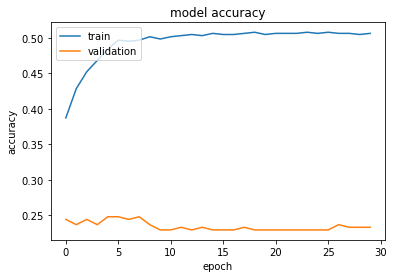

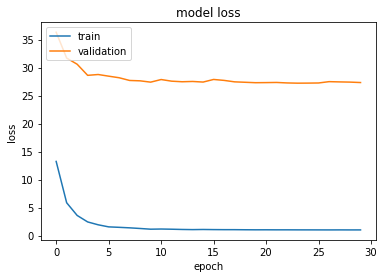

In [156]:
learn_curve_accuracy(history)
learn_curve_loss(history)

## 4.4. Confusion Matrix

In [157]:
def plot_confusion(cm, display_labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    disp = disp.plot()
    plt.show()

#### 4.4.1. For train data

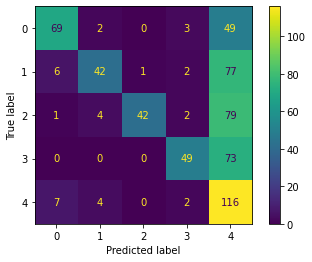

In [158]:
display_labels = [0, 1, 2, 3, 4]
y_pred_tr = np.argmax(vgg_model_transfer.predict(X_train), axis = 1)
cm1_tr = confusion_matrix(y_train, y_pred_tr)
plot_confusion(cm1_tr, display_labels)

#### 4.4.2. For validation data

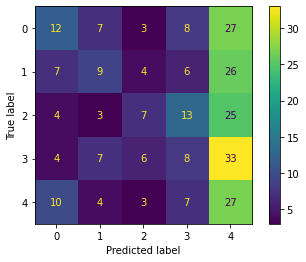

In [159]:
y_pred_v = np.argmax(vgg_model_transfer.predict(X_valid), axis = 1)
cm1_v = confusion_matrix(y_valid, y_pred_v)
plot_confusion(cm1_v, display_labels)

#### 4.4.3. For test data

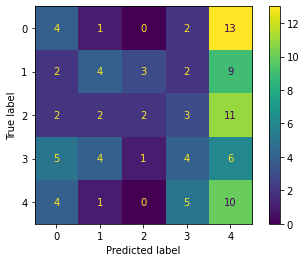

In [160]:
y_pred_t = np.argmax(vgg_model_transfer.predict(imgs_resize_test), axis = 1)
cm1_t = confusion_matrix(y_t, y_pred_t)
plot_confusion(cm1_t, display_labels)

- We can see from the confusion matrices that the model memorizes the training data but has a great bias towards class 4 that refers to class 6 (6 leaves). This bias is also apparent in the other sets, nevertheless, we can see that the diagonal of the validation and test sets has very low values unlike the training set

## 4.5 VGG16 finetuning (Regression)

### 4.5.1. labels for regression

In [161]:
y_reg = make_label(180, len(all_arr), [1, 2, 3, 4, 6])

### 4.5.2. Split the data

In [162]:
X_train_reg, X_valid_reg, y_train_reg, y_valid_reg = train_test_split(imgs_resize, y_reg, test_size=0.3, random_state=30)
X_train_reg = np.array(X_train_reg)
X_valid_reg = np.array(X_valid_reg)

### 4.5.3. Finetuning

In [163]:
### Conv/fully ==> no more than 5,, pool/flatten/1D conv ==> as many
x = Flatten()(x_orig)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='sigmoid')(x)
x = Dense(1, activation='relu6')(x) ## will be 1 in regression and make the y labels as usual [1, 2, 3, 4, 6]

vgg_model_transfer_reg = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_transfer_reg.summary())

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

In [164]:
vgg_model_transfer_reg.compile(loss='mean_squared_error', 
                           optimizer=sgd, 
                           metrics=['accuracy', 'mse'])

history_reg = vgg_model_transfer_reg.fit(X_train_reg, y_train_reg, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_valid_reg, y_valid_reg))

Epoch 1/30
40/40 [==============================] - 8s 201ms/step - loss: 5.9243 - accuracy: 0.1841 - mse: 5.9243 - val_loss: 5.0257 - val_accuracy: 0.2111 - val_mse: 5.0257
Epoch 2/30
40/40 [==============================] - 7s 176ms/step - loss: 4.8698 - accuracy: 0.1937 - mse: 4.8698 - val_loss: 4.2094 - val_accuracy: 0.2111 - val_mse: 4.2094
Epoch 3/30
40/40 [==============================] - 7s 184ms/step - loss: 4.0759 - accuracy: 0.1937 - mse: 4.0759 - val_loss: 3.6925 - val_accuracy: 0.2111 - val_mse: 3.6925
Epoch 4/30
40/40 [==============================] - 6s 162ms/step - loss: 3.6396 - accuracy: 0.1937 - mse: 3.6396 - val_loss: 3.2822 - val_accuracy: 0.2111 - val_mse: 3.2822
Epoch 5/30
40/40 [==============================] - 7s 179ms/step - loss: 3.4257 - accuracy: 0.1937 - mse: 3.4257 - val_loss: 3.1723 - val_accuracy: 0.2111 - val_mse: 3.1723
Epoch 6/30
40/40 [==============================] - 7s 179ms/step - loss: 3.3445 - accuracy: 0.1937 - mse: 3.3445 - val_loss: 3.08

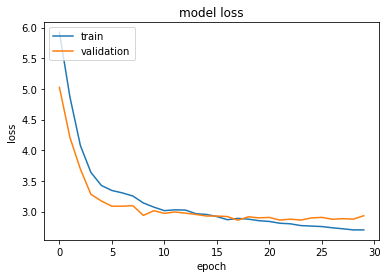

In [165]:
learn_curve_loss(history_reg)

The architecture of regression is changed a bit from classification since with the same exact layers; the accuracy and loss across the train and validation sets were stuck in one value so a dense sigmoid layer was added 

### 4.5.4. MSE 

#### 4.5.4.1. For train data

In [166]:
y_pred_reg_tr = vgg_model_transfer_reg.predict(X_train_reg)

mse_tr = mean_squared_error(y_train_reg, y_pred_reg_tr)
print(mse_tr)

2.67392600923787


#### 4.5.4.2. For validation data

In [167]:
y_pred_reg_v = vgg_model_transfer_reg.predict(X_valid_reg)

mse_v = mean_squared_error(y_valid_reg, y_pred_reg_v)
print(mse_v)

2.9333747236434204


#### 4.5.4.3. For Test data

In [168]:
y_reg_t = make_label(20, len(all_arr_test), [1, 2, 3, 4, 6])
y_pred_reg_t = vgg_model_transfer_reg.predict(imgs_resize_test)

mse_t = mean_squared_error(y_reg_t, y_pred_reg_t)
print(mse_t)

2.6983055752895306


### 4.5.5. Accuracy for the regression by mapping

In [91]:
# y_pred_reg_t
# y_reg_map
# y_reg_t

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

In [169]:
y_reg_map = y_pred_reg_t.copy()

for idx, pred in enumerate(y_pred_reg_t):
  if pred > 0 and pred <= 1:
    y_reg_map[idx] = 1  
  elif pred > 1 and pred <= 2:
    y_reg_map[idx] = 2
  elif pred > 2 and pred <= 3:
    y_reg_map[idx] = 3
  elif pred > 3 and pred <= 4:
    y_reg_map[idx] = 4      
  elif pred > 4:
    y_reg_map[idx] = 6

In [170]:
accuracy_score(y_reg_t, y_reg_map)

0.23

# 4.6. Discussing the performance of 2 models

- For the classification model: the model is horribly overfitting; as the train accuracy is 50%-60% while validation accuracy is of 20%. Also, it's apparent from the losses how the validation loss is very high (35 or more), which shows huge overfitting. This is due to the model lack of generalization since it's a very small dataset with large amount of parameters without regularization or augmentation.
- On the other hand, for the regression model, we can see high convergence in the training and validation sets when it comes to the mean square error. Nevertheless, if we take a further look to the accuracy of this model whether via mapping or via the model metrics in the history, we can see the model is horribly performing on both the training and validation sets (accuracy of < 20%) which means the model is underfitting and not learning, Same goes for the testing data. We may be decieved at first by the high MSE values but after looking more into the acuuracy we can directly say the model is overfitting.

==> Thus we choose to work with the classification model, in order to solve the overfitting of the model via regularization to discover the influence of regularization and augmentation

# 5. Regularization
## 5.1. Model

In [173]:
for layer in vgg_model.layers:
    layer.trainable = False

# last layers output
x_drop = vgg_model.layers[6].output

# x_drop = BatchNormalization()(x_drop)
# x_drop = Dropout(0.5)(x_drop)
x_drop = Flatten()(x_drop)
##
# x_drop = Dropout(0.5)(x_drop)
x_drop = BatchNormalization()(x_drop)
# x_drop = Dropout(0.5)(x_drop)

x_drop = Dense(128, activation='relu')(x_drop)
x_drop = BatchNormalization()(x_drop)
x_drop = Dropout(0.2)(x_drop)
# x_drop = Dense(64, activation='sigmoid')(x_drop)
x_drop = Dense(5, activation='softmax')(x_drop) 

vgg_model_transfer_drop = Model(inputs=vgg_model.input, outputs=x_drop)


## 5.2. Fit the model

In [174]:
vgg_model_transfer_drop.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


history_drop = vgg_model_transfer_drop.fit(X_train, y_train, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_valid, y_valid))

Epoch 1/30
40/40 [==============================] - 10s 237ms/step - loss: 2.4123 - accuracy: 0.1873 - val_loss: 3.9150 - val_accuracy: 0.1926
Epoch 2/30
40/40 [==============================] - 9s 223ms/step - loss: 2.3966 - accuracy: 0.2048 - val_loss: 2.9666 - val_accuracy: 0.1852
Epoch 3/30
40/40 [==============================] - 11s 268ms/step - loss: 2.4441 - accuracy: 0.2111 - val_loss: 2.6532 - val_accuracy: 0.1704
Epoch 4/30
40/40 [==============================] - 8s 198ms/step - loss: 2.3979 - accuracy: 0.2286 - val_loss: 2.5374 - val_accuracy: 0.1741
Epoch 5/30
40/40 [==============================] - 9s 220ms/step - loss: 2.3843 - accuracy: 0.2111 - val_loss: 2.4886 - val_accuracy: 0.1815
Epoch 6/30
40/40 [==============================] - 9s 231ms/step - loss: 2.3997 - accuracy: 0.2032 - val_loss: 2.4651 - val_accuracy: 0.1963
Epoch 7/30
40/40 [==============================] - 9s 231ms/step - loss: 2.3625 - accuracy: 0.2032 - val_loss: 2.4555 - val_accuracy: 0.1889
Epoc

## 5.3. Learning curve

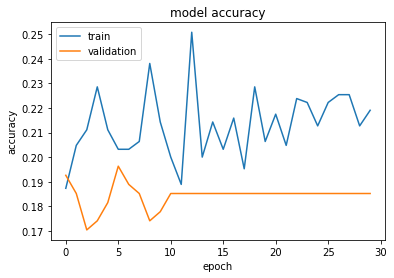

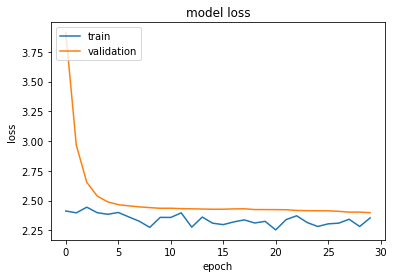

In [175]:
learn_curve_accuracy(history_drop)
learn_curve_loss(history_drop)

### 5.4. Confusion Matrix
#### 5.4.1. Train Data

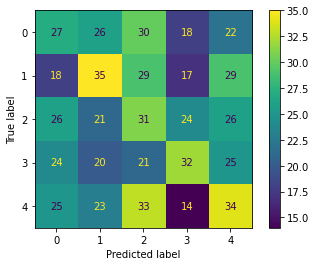

In [176]:
display_labels = [0, 1, 2, 3, 4]
y_pred_drop_tr = np.argmax(vgg_model_transfer_drop.predict(X_train), axis = 1)
cm1_d_tr = confusion_matrix(y_train, y_pred_drop_tr)
plot_confusion(cm1_d_tr, display_labels)

#### 5.4.2. Validation Data

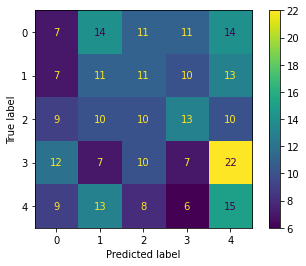

In [177]:
y_pred_drop_v = np.argmax(vgg_model_transfer_drop.predict(X_valid), axis = 1)
cm1_d_v = confusion_matrix(y_valid, y_pred_drop_v)
plot_confusion(cm1_d_v, display_labels)

#### 5.4.3. Test Data

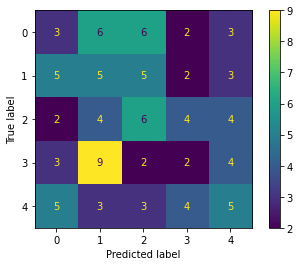

In [178]:
y_pred_drop_t = np.argmax(vgg_model_transfer_drop.predict(imgs_resize_test), axis = 1)
cm1_d_t = confusion_matrix(y_t, y_pred_drop_t)
plot_confusion(cm1_d_t, display_labels)

# 6. Augmentation

## 6.1. Model

In [179]:
for layer in vgg_model.layers:
    layer.trainable = False

# last layers output
x_drop = vgg_model.layers[6].output

# x_drop = BatchNormalization()(x_drop)
# x_drop = Dropout(0.5)(x_drop)
x_drop = Flatten()(x_drop)
##
# x_drop = Dropout(0.5)(x_drop)
x_drop = BatchNormalization()(x_drop)
# x_drop = Dropout(0.5)(x_drop)

x_drop = Dense(128, activation='relu')(x_drop)
x_drop = BatchNormalization()(x_drop)
x_drop = Dropout(0.2)(x_drop)

# x_drop = Dense(64, activation='sigmoid')(x_drop)
x_drop = Dense(5, activation='softmax')(x_drop) 

vgg_model_transfer_drop_aug = Model(inputs=vgg_model.input, outputs=x_drop)
vgg_model_transfer_drop_aug.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


In [ ]:
## Augmentation

In [180]:
batch_size=32 ## 32 images will be created for each image

datagen_args = dict(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.2,0.5],
    brightness_range=[0.2,0.8],
    horizontal_flip=True,
                   rescale=1./255)
datagen = ImageDataGenerator(**datagen_args, validation_split = 0.3)
train_generator = datagen.flow_from_directory('./training',target_size=(64,64),
                                            batch_size=batch_size,interpolation="lanczos",shuffle=True, subset='training')
valid_generator = datagen.flow_from_directory('./training',target_size=(64,64),
                                            batch_size=batch_size,interpolation="lanczos",shuffle=True, subset='validation')


Found 630 images belonging to 5 classes.
Found 270 images belonging to 5 classes.


In [181]:
history_aug = vgg_model_transfer_drop_aug.fit_generator(train_generator, 
                           steps_per_epoch= math.ceil(train_generator.samples//batchSize),
                           epochs=nEpochs, validation_data=valid_generator, validation_steps=math.ceil(valid_generator.samples//batchSize), verbose=1, workers=8)


C:\Users\hosna\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
39/39 [==============================] - 17s 414ms/step - loss: 2.2760 - accuracy: 0.2321 - val_loss: 4.5766 - val_accuracy: 0.2045
Epoch 2/30
39/39 [==============================] - 18s 460ms/step - loss: 2.3189 - accuracy: 0.2248 - val_loss: 3.2285 - val_accuracy: 0.2024
Epoch 3/30
39/39 [==============================] - 20s 488ms/step - loss: 2.3094 - accuracy: 0.2093 - val_loss: 2.8400 - val_accuracy: 0.1842
Epoch 4/30
39/39 [==============================] - 20s 507ms/step - loss: 2.3252 - accuracy: 0.1995 - val_loss: 2.6826 - val_accuracy: 0.2166
Epoch 5/30
39/39 [==============================] - 18s 455ms/step - loss: 2.2699 - accuracy: 0.2296 - val_loss: 2.4492 - val_accuracy: 0.1964
Epoch 6/30
39/39 [==============================] - 20s 514ms/step - loss: 2.3192 - accuracy: 0.1971 - val_loss: 2.1644 - val_accuracy: 0.2247
Epoch 7/30
39/39 [==============================] - 22s 554ms/step - loss: 2.3229 - accuracy: 0.2077 - val_loss: 2.2869 - val_accuracy: 0.2146

### 6.4. Confusion Matrix
#### 6.4.1. Train Data

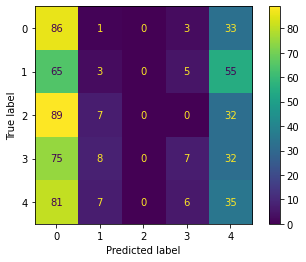

In [182]:
display_labels = [0, 1, 2, 3, 4]
y_pred_drop_tr = np.argmax(vgg_model_transfer_drop_aug.predict(X_train), axis = 1)
cm1_d_tr = confusion_matrix(y_train, y_pred_drop_tr)
plot_confusion(cm1_d_tr, display_labels)

#### 6.4.2. Validation Data

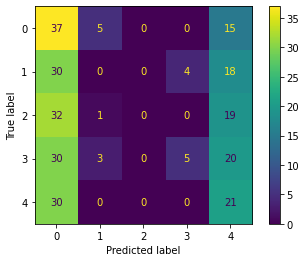

In [183]:
y_pred_drop_v = np.argmax(vgg_model_transfer_drop_aug.predict(X_valid), axis = 1)
cm1_d_v = confusion_matrix(y_valid, y_pred_drop_v)
plot_confusion(cm1_d_v, display_labels)

#### 6.4.3. Test Data

In [184]:
y_pred_drop_t = np.argmax(vgg_model_transfer_drop_aug.predict(imgs_resize_test), axis = 1)
cm1_d_t = confusion_matrix(y_t, y_pred_drop_t)
# plot_confusion(cm1_d_t, display_labels)

### 6.5. Learning Curve

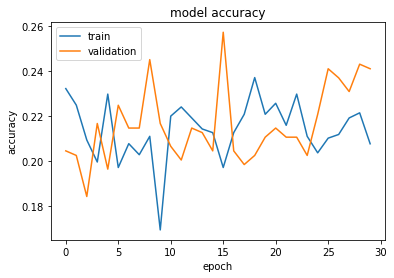

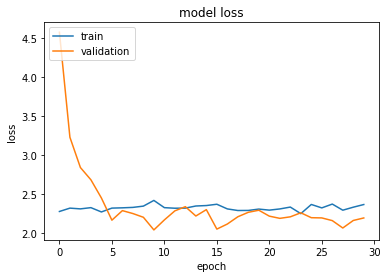

In [185]:
learn_curve_accuracy(history_aug)
learn_curve_loss(history_aug)

# 7. Discussion

- For regularization, we can observe how magnificent it's in reducing the overfitting, where it reduced the training accuracy to 20% from 60%, and now it's converging with the validation accuracy, also the loss had decreased drastically in case of the validation loss where it decreased from 35 to 2.4. In general, this is the objective of regularization which is to reduce overfitting.
- Now for the data augmentation, we can see how it affected the accuracy of the validation data where it made it converge more with the training data which was already good-performing. Moreover, it decreased the loss even more than with the regularization.
- Lastly, since the model has way many parameters that were mainly trained on another dataset with another context, it might be better if we retrain the first layers, get larger dataset, or perform more hyperparameter tuning methods along side with the regularization and augmentation methods to enhance the performance. We may also try adjusting the layers more or add other blocks from VGG16
- So in short; regularization overcame the huge overfitting and augmentation increased the convergence between the two sets; (Note: the model is biased to 2 classes)

- Aside note, in real life we shouldn't augment the validation data as it should be mimicing the real test data which won't be augmented, but the model didn't work unless the validation data was augmented